# Stress Constrained TO Algorithm
This notebook is developed for the "Optimisation & Machine Learning" workshop, organised by UK Metamaterials Network (UKMMN); for educational purposes only.
- Authors: Erin Yu, Sasha Halsey and Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (16/12/2025)
- Comments and corrections to a.panesar@imperial.ac.uk, sasha.halsey20@imperial.ac.uk
-------------------
### Objectives of this lab

1) Add a stress constraint to the TO problem
2) Compare to previous TO results

####  Import library

Run the cell below to import necessarry python libraries for this lab.

If you encounter an error, identify the unsuccessfully-installed library name by reading the error message, cut the corresponding pip install statement (without '#' symbol) into a separate cell and run it. Upon running the pip install cell, then restart the kernel and run the (default) import library cell again.

In [7]:
# --- Clone repository from Git
!git clone https://github.com/amberwang56977/Lab.git
%cd Lab

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from matplotlib import colors
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

Cloning into 'Lab'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 58 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 4.00 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/Lab/Lab


-----------
# The P-Norm Stress Aggregation
We all want a little less stress in our lives, but how much? A loaded structure will have some stress, no matter what. If we changed our problem to 'minimise stress' as the objective, we would end up with no structure - the least stressed structure is no structure at all!

Instead, we shall add stress as a constraint in a similar way to volume / weight, using a limiting factor. You might be thinking - "let's limit it to yield stress". But checking the stress of every element is computationally expensive and is not differentiable, so we can't get the sensitivity value out of it. Therefore we use an approximation for large stresses in the design field. One way is called p-norm stress aggregation, which sums up all the local stress values into a single global value. Similar to SIMP, it uses a penalty-like factor called p-norm, we raise the elemental stress to it's power, sum these values up across the domain and then inverse the power to get a more sensible value. We can increase the value of p-norm to increase the contribution of higher stresses, and as p-norm tends to infinity, the value of the aggregation tends towards the maximum value.

$$
p_{\text{stress}} =
\left(
\frac{1}{N_{\text{el}}}
\sum_{e=1}^{N_{\text{el}}}
\left(
\frac{\sigma_{\text{vm},e}}{\sigma_{\text{yield}}}
\right)^{p_{\text{norm}}}
\right)^{\frac{1}{p_{\text{norm}}}}
$$

where:  

- $N_\text{el}$ = total number of finite elements
- $\sigma_{\text{vm},e}$ = von Mises stress in element $e$
- $\sigma_{\text{yield}}$ = material yield stress
- $p_\text{norm}$ = p-norm exponent (typically 2-20)

Have a play around with some arrays of varying distributions (similar to density) to see the effect the values and p-norm values have on the p-norm aggregation:


In [8]:
# 1) All 0.5
x1 = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

# 2) Uniform spread from 0 → 1
x2 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

def pnorm(x, p): return ((1/len(x1))*np.sum(x**p))**(1.0/p)

p_norm_values = [1, 4, 16]
# compute table entries
table = {
    "x1 (mostly 0.5)": [pnorm(x1, p) for p in p_norm_values],
    "x2 (uniform spread)": [pnorm(x2, p) for p in p_norm_values],}

# print table
print(f"{'':<22} {'p=1':>8} {'p=4':>8} {'p=16':>8}")
print("-" * 50)

for row, vals in table.items():
    print(f"{row:<22} {vals[0]:8.3f} {vals[1]:8.3f} {vals[2]:8.3f}")

                            p=1      p=4     p=16
--------------------------------------------------
x1 (mostly 0.5)           0.500    0.500    0.500
x2 (uniform spread)       0.500    0.693    0.871


-----------
# 1) Adding Another Constraint to the Problem
### Optimisation Framework

Previously we solved a density–based topology optimisation problem with the SIMP formulation.

- **Design variable:**  
  Elemental relative density  
  $$ x_e \in [0,1] $$

- **Objective function:**  
  Minimise compliance (maximise stiffness)
  $$
  \min_x\; C(x) = \mathbf{F}^\mathsf{T}\mathbf{U}(x)
  $$
  where the displacement field satisfies  
  $$
  \mathbf{K}(x)\,\mathbf{U}(x) = \mathbf{F}.
  $$

- **Constraint:**  
  Global volume fraction  
  $$
  \frac{1}{N_e}\sum_{e=1}^{N_e} x_e = V^\ast.
  $$

  In this lab we will formulate the p-norm stress constraint as can then be written as:

  $$
  P_{\rm stress} \le \sigma_{\rm limit}
  $$

  where $\sigma_\text{allow}$ is the allowed stress (e.g. 90% of maximum).  
  This ensures that the structural stress does not exceed the specified limit. In this formulation we will add this as $c_2$ which is the difference between $P_{\rm stress}$ and $\sigma_{\rm limit}$, we want this difference to tend towards 0 to reduce the p-norm stress integral.

  $$
  c_2 = P_{\rm stress} - \sigma_{\rm limit}
  $$



# 1.1) Input parameters

In [9]:
nelx, nely = 40, 20
rmin = 3
penal = 3
Emin, Emax = 1e-9, 1.0
nu = 0.3
volfrac = 0.3
sigma_limit = 0.3
p_norm = 4.0

# 1.2) New optimisation loop with additional constraint defined
The modified iterate function is in iterate_stress_topology.py if you are interested. In there you can change the c2_limit, max_stress_weight and sigma_yield to see it's effect on convergence and resulting design. If you change any parameters inside a separate .py file, you will need to save it and restart the kernel before running in here again

In [10]:
from setup_topology import setup_topology_stress
from iterate_topology import iterate_topology_stress

# Define constants & design variables
params = dict(nelx=nelx, nely=nely, rmin=rmin, Emin=Emin, Emax=Emax, nu=nu, penal=penal, volfrac=volfrac, sigma_limit=sigma_limit, p_norm=p_norm)
state = setup_topology_stress(**params)

# 1.3) Iterate



In [11]:
max_iter = 100
for it in range(max_iter):
    state, info = iterate_topology_stress(state, params)
    print(f"it {it:3d} obj {info['obj']:.4f} change {info['change']:.4f} "
          f"p_stress {info['p_stress']:.4f} c2 {info['c2']:.4f}")
    if info['change'] < 1e-3:
        break

it   0 obj 1762.1004 change 0.2000 p_stress 0.1749 c2 -0.1251
it   1 obj 1112.4919 change 0.2000 p_stress 0.1952 c2 -0.1048
it   2 obj 834.7749 change 0.2000 p_stress 0.2256 c2 -0.0744
it   3 obj 726.0142 change 0.2000 p_stress 0.2519 c2 -0.0481
it   4 obj 657.5520 change 0.2000 p_stress 0.2832 c2 -0.0168
it   5 obj 616.2527 change 0.1844 p_stress 0.2878 c2 -0.0122
it   6 obj 582.7188 change 0.1755 p_stress 0.2950 c2 -0.0050
it   7 obj 556.1895 change 0.1506 p_stress 0.2914 c2 -0.0086
it   8 obj 533.6539 change 0.1679 p_stress 0.2940 c2 -0.0060
it   9 obj 512.5716 change 0.1262 p_stress 0.2895 c2 -0.0105
it  10 obj 493.9130 change 0.1559 p_stress 0.2904 c2 -0.0096
it  11 obj 477.9626 change 0.1101 p_stress 0.2872 c2 -0.0128
it  12 obj 464.0041 change 0.1173 p_stress 0.2886 c2 -0.0114
it  13 obj 452.8197 change 0.0992 p_stress 0.2862 c2 -0.0138
it  14 obj 442.7657 change 0.1242 p_stress 0.2876 c2 -0.0124
it  15 obj 432.2140 change 0.0883 p_stress 0.2865 c2 -0.0135
it  16 obj 423.6256 ch

# 1.4) Plot

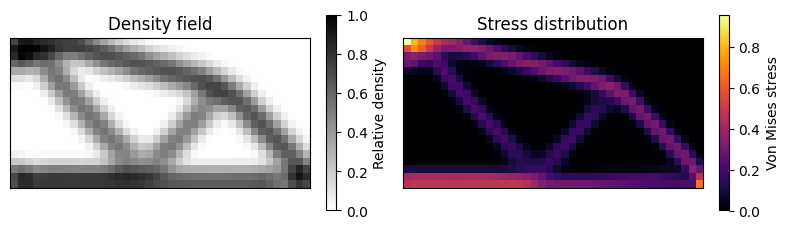

In [12]:
# Prepare plots
density_grid = state['xPhys'].reshape((state['nelx'], state['nely'])).T
sigma_vm_grid = np.flip(state['sigma_vm'].reshape((state['nelx'], state['nely'])).T, axis=0)

# Create side-by-side axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Density field
im1 = ax1.imshow(density_grid, cmap='gray_r', interpolation='none', norm=colors.Normalize(vmin=0, vmax=1))
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.03, pad=0.05)
cbar1.set_label('Relative density')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Density field")

# Stress field
im2 = ax2.imshow(sigma_vm_grid, cmap="inferno", interpolation="none", origin="lower")
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.03, pad=0.05)
cbar2.set_label("Von Mises stress")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Stress distribution")

plt.tight_layout()
plt.show()

----------
### <span style="color:lightblue;">2) Optional: Comparing results</span>

Now try running again, but changing parameters such as c2_limit and max_stress_weight to see how the convergence and design changes.
Keep an eye on the values of p_norm aggregation, c2, obj, as you may need more iterations or relaxing of constraints to ensure convergence.

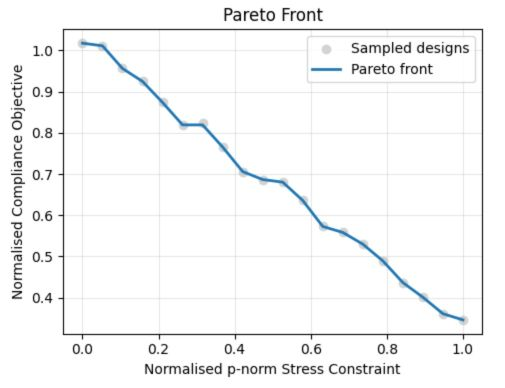